In [20]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

import PyCodesDataProcessingBase.DataProceesingBase_GetBusNet as gbn
import PyCodesDataProcessingBase.DataProceesingBase_GetBusRoute as gbr
import PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol as gtv
import PyCodesDataProcessingBase.DataProcessingBase_GetZonePop as gzp
import PyCodesDataProcessingBase.DataProceesingBase_GetTrainNet as gtn

In [21]:
import importlib
# importlib.reload()
importlib.reload(gzp)
importlib.reload(gtv)

<module 'PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol' from 'C:\\zhouweifile\\Transportation Data\\Singapore Geodatabase\\PyCodesDataProcessingBase\\DataProceesingBase_GetTransitVol.py'>

In [22]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [23]:
# Current Working Directory
os.chdir(r'C:\zhouweifile\Transportation Data\Singapore Geodatabase')
#
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'

# 1. Bus information

The process of construct bus (transit) network

1. `shapefile | geopandas.GeoDataFrame`: bus stop location geography

    There are two source:

    - from datamall static datasets, `shapefile`
    
    - from datamall dynamic datasets (API), `csv`

2. `csv | pandas.DataFrame`: bus route list

    contains the stop list of bus lines
    
3. `networkx.DiGraph`: bus network

    - add edge
    
    - add node

4. `Gephi`: stop (node) list, route (edge) list

## 1.1. Get Bus Stop Location

In [24]:
def BusStopLocPd():
    
    # bus location from the shapefile
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Routes & Stop Location', 'Bus Stop Location (from datamall Static Datasets)',
        'BusStopLocation_Jan2022',  # 'BusStopLocation_Aug2021',
        'BusStop.shp'
    )
    stop_loc = gbn.ReadBusStopLocShp(path)  
    
    # bus location from the csv 
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Routes & Stop Location', 'Bus Stop Location (from datamall API)',
        'bus_stops_2021-12-21',
        'bus_stops_2021-12-21.csv'
    )
    stop_loc1 = gbn.ReadBusStopLocCsv(path)   

    # unify the geometry CRS
    stop_loc1 = stop_loc1.to_crs(stop_loc.crs)
    
    # merge, drop depulicate
    stop_loc = gbn.BusStopLocUpdate(stop_loc, stop_loc1)
    
    return stop_loc


bus_stop_loc = BusStopLocPd()
UNION_CRS = bus_stop_loc.crs

AttributeError: module 'PyCodesDataProcessingBase.DataProceesingBase_GetBusNet' has no attribute 'ReadBusStopLocCsv'

In [ ]:
# bus_stop_loc.to_file('GeoDatabase/shapefiles/bus_stop_loc/bus_stop_loc.shp')

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax1 = bus_stop_loc.plot(markersize=1, ax=ax1)

## 1.2. Get Bus Network

In [ ]:
def BusStopRouteNet():
    
    # get bus stop location
    bus_stop_loc = BusStopLocPd()
    
    # get bus route list csv file
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Routes & Stop Location',
        'Bus Routes (from datamall API)',
        'bus_routes_2021-12-21',
        'bus_routes_2021-12-21.csv'
    )
    bus_route = gbr.ReadBusRoute(path)  
    
    # bus route to network
    bus_net = gbr.BusRoute2Net(bust_route)
    # bus network add bus stop location 
    bus_net = gbr.BusNetAddLoc(net, bus_stop_loc)
    # processe bus stop of network which have no location info
    # still have some problem with this function
    bus_net = gbr.NetProcessing(bus_net)
    
    # nx.write_edgelist(net, path='bus_route_network.csv', delimiter=',')
    # nx.write_gexf(net, 'bus_route_network.gexf')
    # from networkx.drawing.nx_pydot import write_dot
    # write_dot(net, 'bus_route_network.dot')
    # nx.write_gexf(net, 'bus_route_network.gexf')
    
    return bus_route, bus_net
# ----------------------------------------------------------------------


bus_route, bus_net = BusStopRouteNet()

# bus network to node list and edge list, which are input to Gephi
# node_pd, edge_pd = gbr.BusNet2NodeEgesPd(bus_net)
# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Gephi-BusNeworks')
# node_pd.to_csv(os.join.path(path, 'bus_network_node_list_2022-01-19.csv'), index=False)
# edge_pd.to_csv(os.join.path(path, 'bus_network_edge_list_2022-01-19.csv'), index=False)

# bus route to shapefile
bus_route_shp = gbr.Route2Shp(bus_route, bus_stop_loc)

In [ ]:
# route_shp.to_file('GeoDatabase/shapefiles/bus_line/bus_line.shp')

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax1 = route_shp.plot(lw=0.5, alpha=0.5, ax=ax1)
ax1 = bus_stop_loc.plot(color='red', markersize=1, ax=ax1)

## 1.3. Bus Stop Value

In [ ]:
vol_date = '202112'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'transport_node_bus_{0}'.format(vol_date[:4]),
    'transport_node_bus_{0}.csv'.format(vol_date)
)
bus_stop_vol = gtv.GetStopVol(path)
display(bus_stop_vol.head())
# explore the nan of bus_stop_vol
bus_stop_vol.notna().sum().plot(kind='bar', figsize=(16, 4), width=0.8)

bus_stop_vol = gtv.MergeStopVolLoc(bus_stop_vol, bus_stop_loc, merge_how='outer')
bus_stop_vol = gpd.GeoDataFrame(bus_stop_vol)

display(bus_stop_vol.head())
print(type(bus_stop_vol), bus_stop_vol.shape)

In [ ]:
# bus_stop_vol.to_file('GeoDatabase/shapefiles/bus_stop_vol/bus_stop_vol_{0}.shp'.format(vol_date))

## 1.4. Bus Stop OD Passenger Trip

In [7]:
# data: year mouth
VOL_DATE = '202112'

path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'origin_destination_bus_{0}'.format(VOL_DATE[:4]),
    'origin_destination_bus_{0}.csv'.format(VOL_DATE)
)

odtrip = gtv.GetODTrip(path)

display(odtrip.head(10), odtrip.shape)
# odtrip.info()
# allday (312326, 3)

,O_BusStopCode,D_BusStopCode,WD_0,WE_0,WD_1,...,WE_22,WD_23,WE_23,WD_total,WE_total
0,01012,01112,3.0,NaN,98.0,...,6.0,10.0,11.0,998.0,941.0
1,01012,01113,NaN,NaN,29.0,...,5.0,7.0,6.0,670.0,721.0
2,01012,01121,17.0,NaN,42.0,...,1.0,1.0,11.0,484.0,430.0
3,01012,01211,28.0,NaN,15.0,...,5.0,2.0,12.0,478.0,648.0
4,01012,01311,23.0,NaN,81.0,...,10.0,12.0,22.0,966.0,1042.0
5,01012,07371,1.0,NaN,1.0,...,NaN,1.0,4.0,33.0,37.0
6,01012,60011,NaN,NaN,6.0,...,NaN,NaN,NaN,82.0,38.0
7,01012,60021,NaN,NaN,4.0,...,NaN,NaN,NaN,46.0,36.0
8,01012,60031,7.0,NaN,7.0,...,4.0,3.0,7.0,276.0,489.0
9,01012,60159,1.0,NaN,NaN,...,NaN,NaN,NaN,85.0,125.0


(324763, 52)

### 1.4.2. Add OD Trip With Stop Location Info

In [8]:
odtrip_shp =  gtv.ODTrip2Shp(odtrip, bus_stop_loc)

# save to file
# odtrip_shp.to_file('GeoDatabase/shapefiles/bus_stop_vol_OD/bus_OD_{0}.shp'.format(VOL_DATE))

C:\Users\e0751551\.conda\envs\py37geo\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


# 2. Train information

## 2.1. Get MRT Station Location

In [9]:
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Station Location', 
    'Station Location (from datamall Static Datasets)', 
    'TrainStation_Jan2022',
    'MRTLRTStnPtt.shp'
)



path = os.path.join(ROOT_PATH, 'Transport-Network', '[Citylines]Rail Networks', 
    '2022.01.23', 'shapefile', 'MRT_station.shp')

# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Station Location', 
#     'Station Location (from datamall Static Datasets)', 
#     'TrainStation_Jan2022',
#     'MRTLRTStnPtt.shp'
# )

train_sta_loc = gpd.read_file(path)
train_sta_loc = train_sta_loc.to_crs(UNION_CRS)

display(train_sta_loc.shape, train_sta_loc.head(5))

(164, 8)

,station,id,opening,buildstart,closure,line,system,geometry
0,Admiralty,18055,1996,1991,999999.0,North-South Line,SMRT Trains,POINT (24400.103 46923.089)
1,Aljunied,18072,1989,1985,999999.0,East-West Line,SMRT Trains,POINT (33516.819 33190.819)
2,Ang Mo Kio,17963,1987,1987,999999.0,North-South Line,SMRT Trains,POINT (29801.909 39120.901)
3,Bakau,18270,2003,2000,999999.0,Sengkang LRT line,SBS Transit,POINT (36027.295 41112.472)
4,Bangkit,18260,1999,1996,999999.0,Bukit Panjang LRT Line,SMRT Trains,POINT (21247.236 40225.625)


## 2.2. Get MRT Route Location

In [41]:
path = os.path.join(ROOT_PATH, 'Transport-Network', '[Citylines]Rail Networks', 
    '2022.01.23', 'shapefile', 'MRT_route.shp')

train_route_loc = gpd.read_file(path)
train_route_loc = train_route_loc.to_crs(UNION_CRS)

display(train_route_loc.head(5))

,start,end,line,system,geometry
0,18055,18054,North-South Line,SMRT Trains,"LINESTRING (24400.103 46923.089, 22875.496 464..."
1,18055,18056,North-South Line,SMRT Trains,"LINESTRING (24400.103 46923.089, 26520.079 478..."
2,18072,18210,East-West Line,SMRT Trains,"LINESTRING (33516.819 33190.819, 34593.550 333..."
3,18072,18071,East-West Line,SMRT Trains,"LINESTRING (33516.819 33190.819, 32232.537 326..."
4,17963,17962,North-South Line,SMRT Trains,"LINESTRING (29801.909 39120.901, 29293.317 404..."


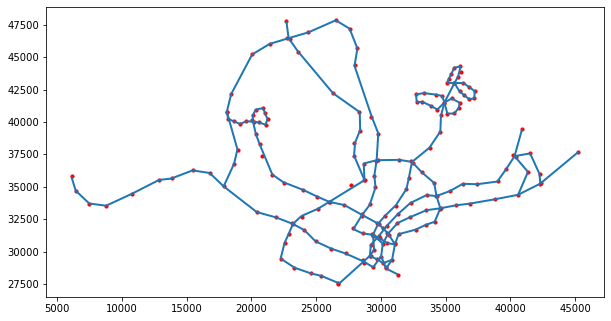

In [42]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax1 = train_route_loc.plot(lw=2, alpha=1, ax=ax1)
ax1 = train_sta_loc.plot(color='red', markersize=10, ax=ax1)

## 2.3. MRT Station Volume

In [39]:
vol_date = '202112'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Volume', 
    'transport_node_train_{0}'.format(vol_date[:4]),
    'transport_node_train_{0}.csv'.format(vol_date)
)

train_sta_vol = gtv.GetStopVol(path)
display(train_sta_vol.head(5))
print(train_sta_vol['BusStopCode'].unique().shape, train_sta_loc.shape)

,IN_WD_0,IN_WD_10,IN_WD_11,IN_WD_12,IN_WD_13,...,IN_WD_total,IN_WE_total,OUT_WD_total,OUT_WE_total,BusStopCode
0,0.0,3372.0,3151.0,3163.0,2944.0,...,58739.0,15034.0,62486.0,17459.0,BP10
1,NaN,3524.0,3346.0,3238.0,3001.0,...,61677.0,16128.0,49753.0,12897.0,BP11
2,NaN,2373.0,2521.0,2352.0,2287.0,...,42597.0,10113.0,31115.0,7519.0,BP12
3,0.0,1578.0,1537.0,1505.0,1324.0,...,27981.0,7070.0,17984.0,4242.0,BP13
4,NaN,3062.0,3107.0,2993.0,2626.0,...,54480.0,14713.0,42139.0,12347.0,BP2


(164,) (164, 8)


# 3. Zone information

## 3.1. Read Zone

In [ ]:
path = os.path.join(ROOT_PATH, 'Zones',
    'master-plan-2019-subzone-boundary-no-sea', 
    'master-plan-2019-subzone-boundary-no-sea-kml.kml'
)

# transform the CRS of zone
zone = gzp.ReadZoneShp(path).to_crs(bus_stop_loc.crs)
# print(zone.columns)

zone1 = zone.dissolve(by='PLN_AREA_C', as_index=False, aggfunc='first')
# 'SUBZONE_C', 'PLN_AREA_C', 'REGION_C'

display(zone.head())
display(zone1.head())

In [ ]:
# zone.to_file('GeoDatabase/shapefiles/zone/zone.shp')

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone.centroid.plot(color='green', markersize=2, ax=ax1)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone1.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone1.centroid.plot(color='green', markersize=2, ax=ax1)

## 3.2. Read Population

In [ ]:
path = os.path.join(ROOT_PATH, 'Populations',
    'singapore-residents-by-subzone-and-type-of-dwelling-2011-2019', 
    'planning-area-subzone-age-group-sex-and-type-of-dwelling-june-2011-2019.csv')
pop_raw = gzp.ReadZonePop(path)  

display(pop_raw.head())
# check SUBZONE_N and PLN_AREA_N column categorical values
# of pop_raw and zone whether are identical
gzp.CheckPopAndZoneMatch(pop_raw, zone)

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop1 = gzp.PopExtract(pop_raw, attrib='year', zone_level='PLN_AREA_N')
display(pop.head())
display(pop1.head())

## 3.3. Merge Zone and Population

In [ ]:
zone_pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
zone_pop1 = gzp.ZoneAddPop(zone1, pop1, zone_level='PLN_AREA_N')

display(zone_pop.head())
display(zone_pop1.head())

print(zone_pop.shape, zone_pop1.shape)


'''
# save file
pop = gzp.PopExtract(pop_raw, attrib='year', zone_level='SUBZONE_N')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_year.shp')

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_type_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='sex', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_sex_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='age_group', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_age_2019.shp')
'''

In [ ]:
data = zone_pop
col = 'total'

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax1 = data.plot(col, 
    alpha=0.3, edgecolor='black', linewidth=1, ax=ax1, 
    vmax=data[col].max(), vmin=data[col].min(),
    # cmap='cool', 
    legend=True, cax=cax
)